# Email Tracking BOT Detection - Data Exploration

## Problem
More and more, email tracking data is originating from BOT activity as opposed to the actual person the email is intended for.  Through manual investigation, most of these bots are not malicious, but come from protective services like Anti-Phishing devices meant to protect the email contact from dangerous emails.  

The goal is not to reject requests from known BOTS.  We still want these protective services to see the links and to be able to judge the safety of the email message.  But if we can predict if the request is from one of these BOT services, we could mark or discard the activity to prevent skewing of activity reporting on the campaign.

## Email Tracking Overview:


![alt text](Diagrams/Tracking.png "Tracking Overview") 

## Terminology
- **Subscriber List** - A list of email addresses that have opted into receiving emails from the company.  A list have have many emails.  A company can have many subscriber lists.  An email can belong to many lists and many companies.  But a subscriber list can only belong to one company.
- **Campaign** - An email message send out by a company.  This email is sent to some or all the subscribers on the list.  With the exception of some limited personalization, all subscribed receive the same content.  A list can have many campaigns, but a campaign can only have one subscriber list.
- **Inbox** - What the contact sees as a unique message in their inbox (Outlook, GMail, etc.).  If a company sends a single campaign to 1 million contacts, there will be 1 million InboxIDs for that campaign.
- **Request** - A tracking HTTP request from an action the contact takes on a message in their inbox.  There are several types of requests, but they are primarily Opens which are pixel image reqeusts and Clicks.
- **Link** - A clickable and trackable URL embedded in the email message.  The tracking system identifies the click, saved the tracking information and returns a redirect URL so the contact gets to their intended URL destination.
- **AS Number/Name** - Who owns the block of IP address.  https://en.wikipedia.org/wiki/Autonomous_system_(Internet)
- **CIDR** - A notation of shows us what range of IP address are in a block. https://en.wikipedia.org/wiki/Classless_Inter-Domain_Routing
- **Network Address Trasnlation - NAT** - Most computers and phones do not have a public IP Address.  NAT is a way for many different computer to reuse the same public IP Address. https://en.wikipedia.org/wiki/Network_address_translation   

## Columns 

 #### Raw columns recieved with HTTP Request:
 
 - **InboxID** - Uniquely identifies the Campaign and the email it was sent to.
 - **Company** - Who owns the campaign
 - **RequestType** - 
     - *Open* - The contact downloaded images for the message.  A tracking pixel added to the HTML body of the message makes a request to the tracking system to identify who opened the message.
     - *Read* - The message was opened for a pre-defined period of time.
     - *Click* - The contact clicked on a URL in the message and the tracking system sees this request.
     - *Browser Link* - The contact requested seeing the message in a web browser.  Mostly used if the message did not render well in the email client.
 - **RequestDate** - The date of the request (i.e. Open or Click).
 - **Link** - A hash of the URL requested.
 - **IPAddress** - The IP Address the requested was generated from.
 - **UserAgent** - A string submitted by email clients/browsers and Bots that attempts to identify the browser type.  This can be made any string you want to it can be easily modified by Bots.
 
 
 #### Columns that can be looked up from the InboxID: 
 
 - **SendDate** - The date and time (1 minute precision) of when the message was sent to that email.  If a company sends a campaign to 5 million email, the send might take 10-20 mins.  The SendDate is the date when that message was sent out and not the date the campaign started.
 - **List** - A unique ID of the subscription list.  
 - **Campaign** - A unique ID of the campaign.
 - **UserID** - A unique ID of the email address the message was sent to.
 - **DomainID** - A unique ID of the domain of the email address the message was sent to.
 - **EmailDomain** (redundant with DomainID)- A unique ID of the domain of the email address the message was sent to.
 - **EmailRootLevelDomain** - The top level domain of the email domain.  i.e. fred@gamil.com - ".com", mary@harvard.edu - 
 
 
 #### Columns that are derived from IP lookup data:
 
 - **AS Name** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **AS Number** - Owner of the IP Range (see above).  Can be Null if owner not found in ASN database.
 - **CIDR Range** - The block the IPAddress belongs to (see above).  Can be Null if owner not found in ASN database.".edu"
 - **Lat/Long** - Found from an IP Lookup service.  Data available is not center of mass, but just the first Lat/Log in the polygon.
 - **OlsonName** - Time Zone of the location the request came from. Also found via the IP Lookup.
 
#### Calculated columns after InboxID lookup is performed
 
 - **SendRequestSeconds** - Number of seconds between the time the message was sent to the request date.


 ## Hierarchies in Data
 
 ![alt text](Diagrams/Hierarchies.png "Hierarchies in Data")

![alt text](Diagrams/NAT.png "NAT") 

Most computers and phones do not use a stand-along IP Address.  NAT is used to give a common public IP address for out web requests to the internet.  

### Because of this, an IP Address can be used my many people and many computers/phones.

#### So a single IP = 100 People

Common places where NAT is used:
- **Work** - Most companies will use NAT with a small number of public IP Address.  If the company has 100 employees, all 100 employees will reuse the same few public IP Address.
- **Internet Service Provider** - The subscribers to an ISP will share public IP Address.  Bigger ISPs can have many subnets and therefore a lot of public IP Address.  But there can still be hundreds of people reusing the same IP Address.
- **Cell Phone Carriers** - NAT is used by you phone carriers.  Carriers like AT&T have thousands of public IP Addresses, but millions of cell phones.
- **Cloud Computer Platforms (AWS)** - Users of these platforms may or may not use NAT.  So, if the IP Address is traced back to Amazon Web Services, this public IP may or may not belong to a single AWS account.

### The result, IP Address does not map to a person or email


In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from IPython.display import display
import pytz
from dateutil.tz import tzutc
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import os.path
from os import path
import pickle

### BotDataSet Class

We will use a class to make sure the **loading**, **cleanup** and **sessionization** is done consistantly for both the IP Reputation and the Campaing dataset.  This class will also give us code reuse for the trainging and testing datasets.

In [2]:
exec(open("BotDataSet.py").read())

In [3]:
botDataSet = BotDataSet()
botDataSet.loadCSV('C:/data/C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8.csv')
df = botDataSet.df

In [4]:
pd.options.display.max_columns = None
display(df.head()) 
print(df.shape)
print('RequestDate Range: {}:{}'.format(df['RequestDate'].min(), df['RequestDate'].max()))
df.nunique()

,InboxID,Company,List,Campaign,RequestType,SendDate,RequestDate,Link,IPAddress,UserAgent,AS Name,AS Number,CIDR Range,UserID,DomainID,EmailDomain,EmailRootLevelDomain,CountryCode,RegionCode,PostalCode,Lat,Long,OlsonName,SendRequestSeconds,SendRequestSeconds_ln
0,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{2091AC3A-12C7-8FBF-3AA8-8C8C5F874EE2},{9AD7D4CE-E247-DA9B-6E99-F5255E45F42F},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
1,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{C7757DCC-7F71-8FAB-6836-0B061F8668F0},{1508EC2E-DA30-4661-442A-74EAD9243FE2},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
2,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{B68FB2B6-F5FF-B7DA-22DD-589DF7AE29F7},{08E594F2-2009-3FB3-17F6-A37ABD24F6C9},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
3,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{81E9F200-AB2B-54DE-B91D-506F173DA998},{4A03B84C-1010-D5C7-3541-127FBB258929},{613F6166-E32A-4AE1-9FC4-7927349BDFE7},Unknown,Unknown,Unknown,{689E664D-1110-0BB1-7C6F-0DB872A731FA},{80050545-EC9D-D79E-A18E-1666F4C81AAB},{685CD069-4D61-F6AD-A3BE-0D814C0BC40C},.org,US,VA,22102,38.98191,-77.256903,America/New_York,0,1.0
4,{F4724933-4570-E4BE-9B17-3D0928E9EE76},{6C357BE7-9D8A-9D1E-FD3C-9D4C45077541},{15D09884-3FDD-8390-8493-A428F11F308D},{C1D499D6-AA43-9ABA-4EFD-0D97D0A33BE8},Click,2020-01-17 09:03:00,2020-01-17 09:03:00,{048D23DD-04F1-D783-DB55-4BA2891DAA60},{49F7F9A3-19F9-6E8A-5896-BC10581E5868},{30634283-D150-237A-87FD-DA097EBBE5B9},"Amazon.com, Inc.",16509,{4ED21F0C-8573-052A-670B-E4D315133AF5},{F89AA673-49FE-433F-7447-040277C7D897},{C595CAFD-E63F-58ED-E8C8-8DB70C548720},{C6A21CB1-169B-B0F6-A812-35899D02D459},.org,US,OR,97207,45.850021,-119.631154,America/Los_Angeles,0,1.0


(24058, 25)
RequestDate Range: 2020-01-17 09:03:00:2020-01-21 11:49:00


InboxID                  11566
Company                      1
List                         1
Campaign                     1
RequestType                  1
SendDate                    13
RequestDate               2187
Link                        37
IPAddress                10339
UserAgent                 1181
AS Name                     21
AS Number                   22
CIDR Range                 354
UserID                   11566
DomainID                   952
EmailDomain                952
EmailRootLevelDomain        32
CountryCode                 77
RegionCode                 148
PostalCode                2572
Lat                       1612
Long                      1659
OlsonName                   79
SendRequestSeconds        2180
SendRequestSeconds_ln     2180
dtype: int64

# Only One Metrizable Column in Raw Request Data
## But this metric is one of the major factors that we anticipate will help us identify BOTs.

Mose of the click BOTs are safty devices that examin the risk of the email before it is released to the contact's inbox. So to prevent causing a long delay, the BOTs will want to process the links as soon as they are recieved.  Through manual, most of the suspected BOTs click the message within 1 or 2 minutes after send went out.

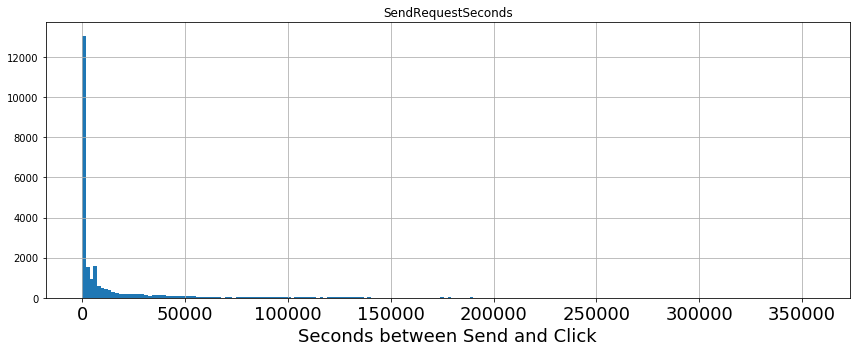

In [5]:
df.hist(column='SendRequestSeconds', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Seconds between Send and Click", fontsize=18)
plt.tight_layout()
plt.show()

## As you can see from the histogram, there is an overwelming number of clicks in the first few minusts after the send.

#### To even out this distribution, the BotDataSet class created a calculated column called **SendRequestSeconds_ln**

This was done by taking the natural log of the SendRequestSeconds.  To avoid zero and negative, the number e was added before the the log was taking.  This make the bottom of the scale = 1.  To give a feel of the upper limit of the this value, 2 days (172800 seconds) would give a value of 14.77.

## $ SendRequestSeconds\_ln = log_{e}(SendRequestSeconds + e) $

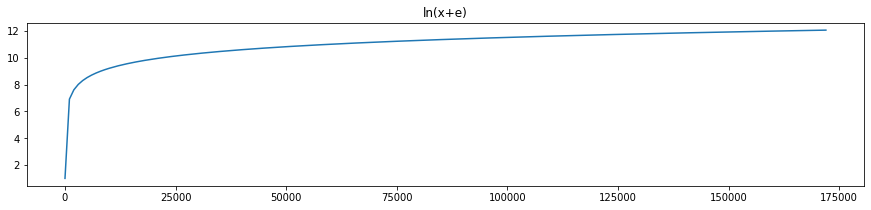

In [6]:
def ln_seconds_plus_e(t):
    return np.log(t + np.exp(1)) 
seconds = range(0, 172800, 1000)
seconds_ln =  ln_seconds_plus_e(seconds)
f = plt.figure(figsize=(15, 3))
plt.plot(seconds, seconds_ln)
plt.title('ln(x+e)')
plt.show()

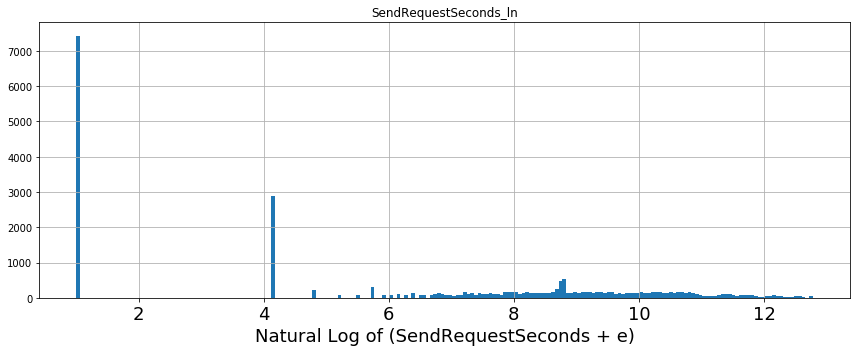

In [7]:
df.hist(column='SendRequestSeconds_ln', bins=200, figsize=(12,5), xlabelsize=18)
plt.xlabel("Natural Log of (SendRequestSeconds + e)", fontsize=18)
plt.tight_layout()
plt.show()

# Sessionization

Because of NAT, an IP Address might be reused by many different people and many different computers/phones.  So we cannot say click activity on the same IP Address for a 1,000 different emails must be a BOT.  It is just as likely that the IP Address is used by a cell phone carrier.

Sessionization help to mitigate this problem.  Requests coming from the same IP Address in a short sequence of time has a much greater chance of being from the same person/computer.  Combining IP and User Agent would tend to strengthen the correlation to a single person.

If we sessionize based on InboxID, we have a very good chance of getting requests from a single person.  But if the requests are from a BOT, they could be processing many different InboxIDs on several IP/UserAgents at the same time.




![alt text](Diagrams/Sessionization.png "Sessionization")


## Extend Dataframe with Session Columns

#### We want to sessionize in 3 ways, the InboxID, P Address and the combination of IP Address and User Agent

### Inbox Based
- **InboxID** - This is straight forward.  Any requests from the same inbox message will have the same session if there are not any gaps over 2 mins.  This type of session will be used to judge behavior of the "Contact".

### IP Based
- **IP Address** - This type of sessionization will be used to judge the behavior of IP Address from where the requests come from.  If I click links from 2 different messages, the 2 InboxIDs will come from the same IP Address.  But it might be unusual to have requests from many different InboxIDs from the same IP. Especially if the inboxes are to different emails and different email domains.
- **IP & UserAgent** - Historically, BOT detection has been done with a status list of IP/UserAgent combinations.  Unsophisticated BOTs can use only 1 or 2 IP Address and always use the same User Agent string.  These were easy to detect.  Even though this approach is not adequate with the current times, the combination of IP/UserAgent is still very much a valid ay to sessionize requests.  This holds up with manually scanning of data where we see the same UserAgent string used over and over again.  Even if the UA they use is a common one, i.e. iPhone 10, the fact that the same IP Address uses the exact same User Agent over and over again for many different emails could be highly suspicious.


Below, we use the BotDataSet class to append session columns to our dataframe.


In [8]:
max_session_time_gap = timedelta(seconds=120)

session_columns = {'InboxSessionID':('InboxID', None), 
                   'IPSessionID':('IPAddress', None),
                   'IPUASessionID':('IPAddress', 'UserAgent')}

for t in session_columns.items():
    new_column_name, group_tuple = t
    group_column_1, group_column_2 = group_tuple
    botDataSet.loadSessionColumn(new_column_name, max_session_time_gap, group_column_1, group_column_2)

df = botDataSet.df

In [9]:
display_columns = ['RequestDate', 'InboxID', 'IPAddress', 'CIDR Range', 'AS Number']
display_columns.extend(list(session_columns.keys()))

sdf = df[display_columns]
display(sdf.head()) 
sdf.nunique()

,RequestDate,InboxID,IPAddress,CIDR Range,AS Number,InboxSessionID,IPSessionID,IPUASessionID
0,2020-01-17 09:03:00,{85A0B8A0-4712-1803-93FC-B8461995CFC9},{9AD7D4CE-E247-DA9B-6E99-F5255E45F42F},Unknown,Unknown,8089516789378823228,7391274423646433569,-2750652298090037204
71,2020-01-17 09:03:00,{834A4BE1-D5F7-2143-E451-B7D2189175AE},{6AC33884-ADE3-2F3E-6DD7-1731EC5D2945},{BF61FA52-8010-2731-2B4E-0C77A6C05E6A},16509,-3119273665877760006,106608387793173938,-5561470762588430427
91,2020-01-17 09:03:00,{183046DF-1656-1D94-BBF1-63289C49F43C},{0793D471-B890-C0C1-2C0B-DF4882B1D58C},{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},16509,-6778629148817076227,4764858454980538349,-3955246072950266624
92,2020-01-17 09:03:00,{A36C9EE8-B8CC-AC57-DC47-CEA3D1F99726},{0793D471-B890-C0C1-2C0B-DF4882B1D58C},{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},16509,-1610736379331273100,4764858454980538349,-3955246072950266624
93,2020-01-17 09:03:00,{30E5C814-9797-EA1B-ED40-4165172C81F8},{0793D471-B890-C0C1-2C0B-DF4882B1D58C},{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},16509,-3505474618340884276,4764858454980538349,-3955246072950266624


RequestDate        2187
InboxID           11566
IPAddress         10339
CIDR Range          354
AS Number            22
InboxSessionID    12398
IPSessionID       11532
IPUASessionID     11638
dtype: int64

# Data exploration of the 3 Session Types

### Approach (for each Session Type):
- **Build Aggregations** - i.e. UniqueInboxIDs, UniqueEmails, SessionDuration.

- **Reduce Aggregations** - Build another DF with just the aggregations we want to use in our unsupervised learning.  We will use the other aggregations for visualization after we add labels.

- **Rescale Features** - Use MinMaxScaler.

- **Look at Covariance** - Ideally, we would like to see a lot of independence between the features.

- **Explore Clustering** - Since the features are derived from aggregations, most of the data will be count data.  Count data tends to follow an exponential decay PDF.  Since our features are not Gaussian distributed, they will not be clustered around a mean and will be non-isotropic. A lot of the scatter plots will tend to show grouping around lines and curves.  Because of this, DBSCAN looks to be a good fit for our initial clustering.


## Build Aggregations

Most of the aggregations will be the same for all the session types.  But there will be some differences.  
For example, the IP/UserAgent session does not make sense to use **UniqueUserAgents** since this type of session only has one User Agent string.

### Build Column Lists

In [10]:
# todo: Explicit lists vs something more generic?  Here explicit was chosen, but might be able to find a cleaner way?

# Inbox Session
Inbox_agg = {  'InboxID':'min',
               'InboxSessionID':'size',
               'UserAgent':'nunique',
               'CIDR Range':'nunique',
               'AS Number':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}
Inbox_agg_renames = {'InboxSessionID': 'RequestCount',
                     'UserAgent': 'UniqueUserAgents', 
                     'CIDR Range': 'UniqueCIDRs', 
                     'AS Number': 'UniqueASNs', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

Inbox_unsup_columns = ['RequestCount',
                       'UniqueUserAgents',
                       'UniqueCIDRs',
                       'UniqueASNs',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration']    

# IP Sessions
IP_agg = {     'IPAddress':'min',
               'UserAgent':'nunique',
               'IPSessionID':'size',
               'InboxID':'nunique', 
               'UserID':'nunique', 
               'EmailDomain':'nunique', 
               'EmailRootLevelDomain':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}


IP_agg_renames = {   'IPSessionID': 'RequestCount', 
                     'UserAgent': 'UniqueUserAgents', 
                     'InboxID': 'UniqueInboxIDs', 
                     'UserID': 'UniqueEmails', 
                     'EmailDomain': 'UniqueEmailDomains', 
                     'EmailRootLevelDomain': 'UniqueEmailRootLevelDomain', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

IP_unsup_columns = [   'RequestCount',
                       'UniqueInboxIDs',
                       'UniqueEmails',
                       'UniqueEmailDomains',
                       'UniqueEmailRootLevelDomain',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration',
                       'UniqueUserAgents']

# IPUA Sessions
IPUA_agg = {   'IPAddress':'min',
               'UserAgent':'min',
               'IPUASessionID':'size',
               'InboxID':'nunique', 
               'UserID':'nunique', 
               'EmailDomain':'nunique', 
               'EmailRootLevelDomain':'nunique',
               'Link':'nunique',
               'SendRequestSeconds':'mean', 
               'SendRequestSeconds_ln' : 'mean',
               'RequestDate':lambda x: (x.max() - x.min()).seconds}


IPUA_agg_renames = { 'IPUASessionID': 'RequestCount', 
                     'InboxID': 'UniqueInboxIDs', 
                     'UserID': 'UniqueEmails', 
                     'EmailDomain': 'UniqueEmailDomains', 
                     'EmailRootLevelDomain': 'UniqueEmailRootLevelDomain', 
                     'Link': 'UniqueLinks',  
                     'SendRequestSeconds': 'MeanSendRequestSeconds', 
                     'SendRequestSeconds_ln': 'MeanSendRequestSeconds_ln', 
                     'RequestDate': 'SessionDuration'}

IPUA_unsup_columns = [ 'RequestCount',
                       'UniqueInboxIDs',
                       'UniqueEmails',
                       'UniqueEmailDomains',
                       'UniqueEmailRootLevelDomain',
                       'UniqueLinks',
                       'MeanSendRequestSeconds_ln',
                       'SessionDuration']

## Run groupby for each Session Type

### Inbox

In [11]:
# Inbox
df_Inbox_agg = df.groupby(['InboxID']).agg(Inbox_agg)
df_Inbox_agg.rename(columns=Inbox_agg_renames, inplace=True)

# IP Only
df_IP_agg = df.groupby(['IPSessionID']).agg(IP_agg)
df_IP_agg.rename(columns=IP_agg_renames, inplace=True)

#IP and User Agent
df_IPUA_agg =  df.groupby(['IPUASessionID']).agg(IPUA_agg)
df_IPUA_agg.rename(columns=IPUA_agg_renames, inplace=True)

## Reduce Aggregations

use copy() to avoid views

In [12]:
df_Inbox_agg_unsup = df_Inbox_agg[Inbox_unsup_columns].copy()
df_IP_agg_unsup = df_IP_agg[IP_unsup_columns].copy()
df_IPUA_agg_unsup = df_IPUA_agg[IPUA_unsup_columns].copy()

## Rescale Features

We will use these new DataFrames for out unsupervised data exploration

In [13]:
def getScaledDataFrame(df):
    mms = MinMaxScaler()
    mms.fit(df)

    result = pd.DataFrame(mms.transform(df))
    result.columns = df.columns
    result.index = df.index
    return result

df_Inbox_agg_unsup_s = getScaledDataFrame(df_Inbox_agg_unsup)
df_IP_agg_unsup_s = getScaledDataFrame(df_IP_agg_unsup)
df_IPUA_agg_unsup_s = getScaledDataFrame(df_IPUA_agg_unsup)
unsup_data = {'Inbox':df_Inbox_agg_unsup_s, 'IP Only':df_IP_agg_unsup_s, 'IP + UA':df_IPUA_agg_unsup_s}

## Look at Covariance


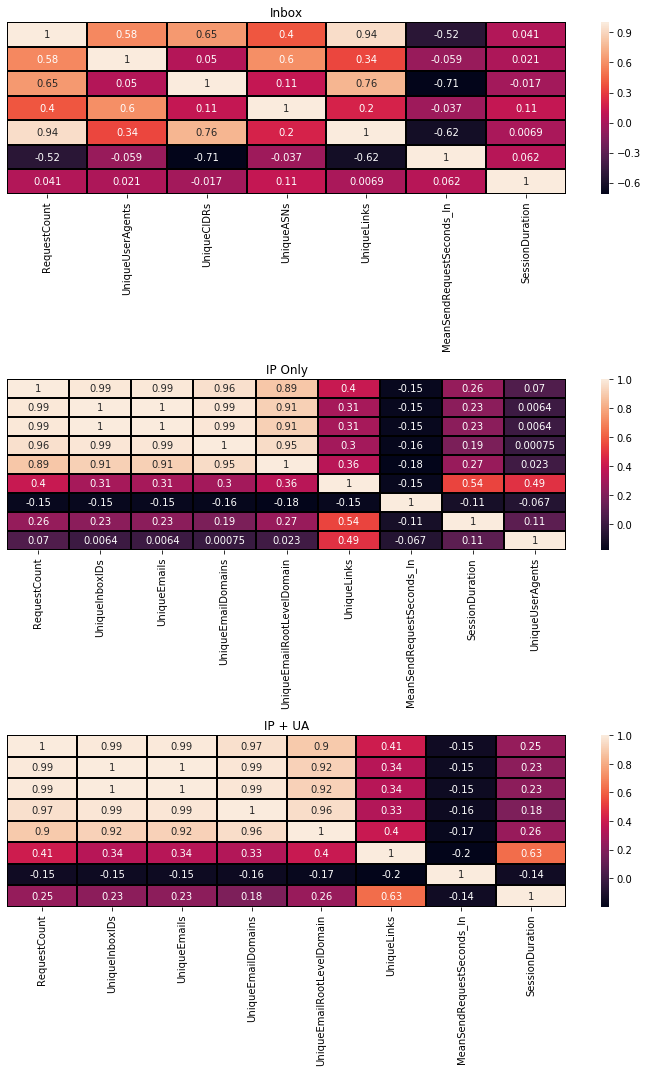

In [14]:
f = plt.figure(figsize=(10, 15))    
gs = f.add_gridspec(3,1)
i = 0
    
for df_name, df in unsup_data.items():
    ax = f.add_subplot(gs[i])
    corr = df.corr()
    sns.heatmap(corr, 
        xticklabels=True,
        yticklabels=False, 
        linewidths=1,
        linecolor='black',
        annot=True)
    plt.title(df_name)   
    i += 1

plt.tight_layout()
plt.show()

## Conclusions:

The Inbox session data does look there is a fair amount of covariance, but without excessively dependent.  PCA might make sense, but since we only have 7 features, we will skip this step.

Between the 2 IP bases sessions, the correlation matrix does not look very different.  Since historically we know the combination of IP and User Agent have be successful in filtering out BOT activity, we will choose to use it for out IP session.


# Explore Clustering



![alt text](Diagrams/MergingSessionDataFrames.png "MergingSessionDataFrames")

# Clustering IP/UA Session Data

## Let’s look at all the scatter plots to help us choose the best unsupervised clustering model

As you can see, the data does not form any obvious globular clusters.  Since this data is mostly aggregate counts, the distributions are more likely exponential decay then Gaussian.  

Because of this, K-Mean would probably **not** be a good fit.  An approach using nearest neighbors like **DBSCAN** should be a good probably be a good starting point.


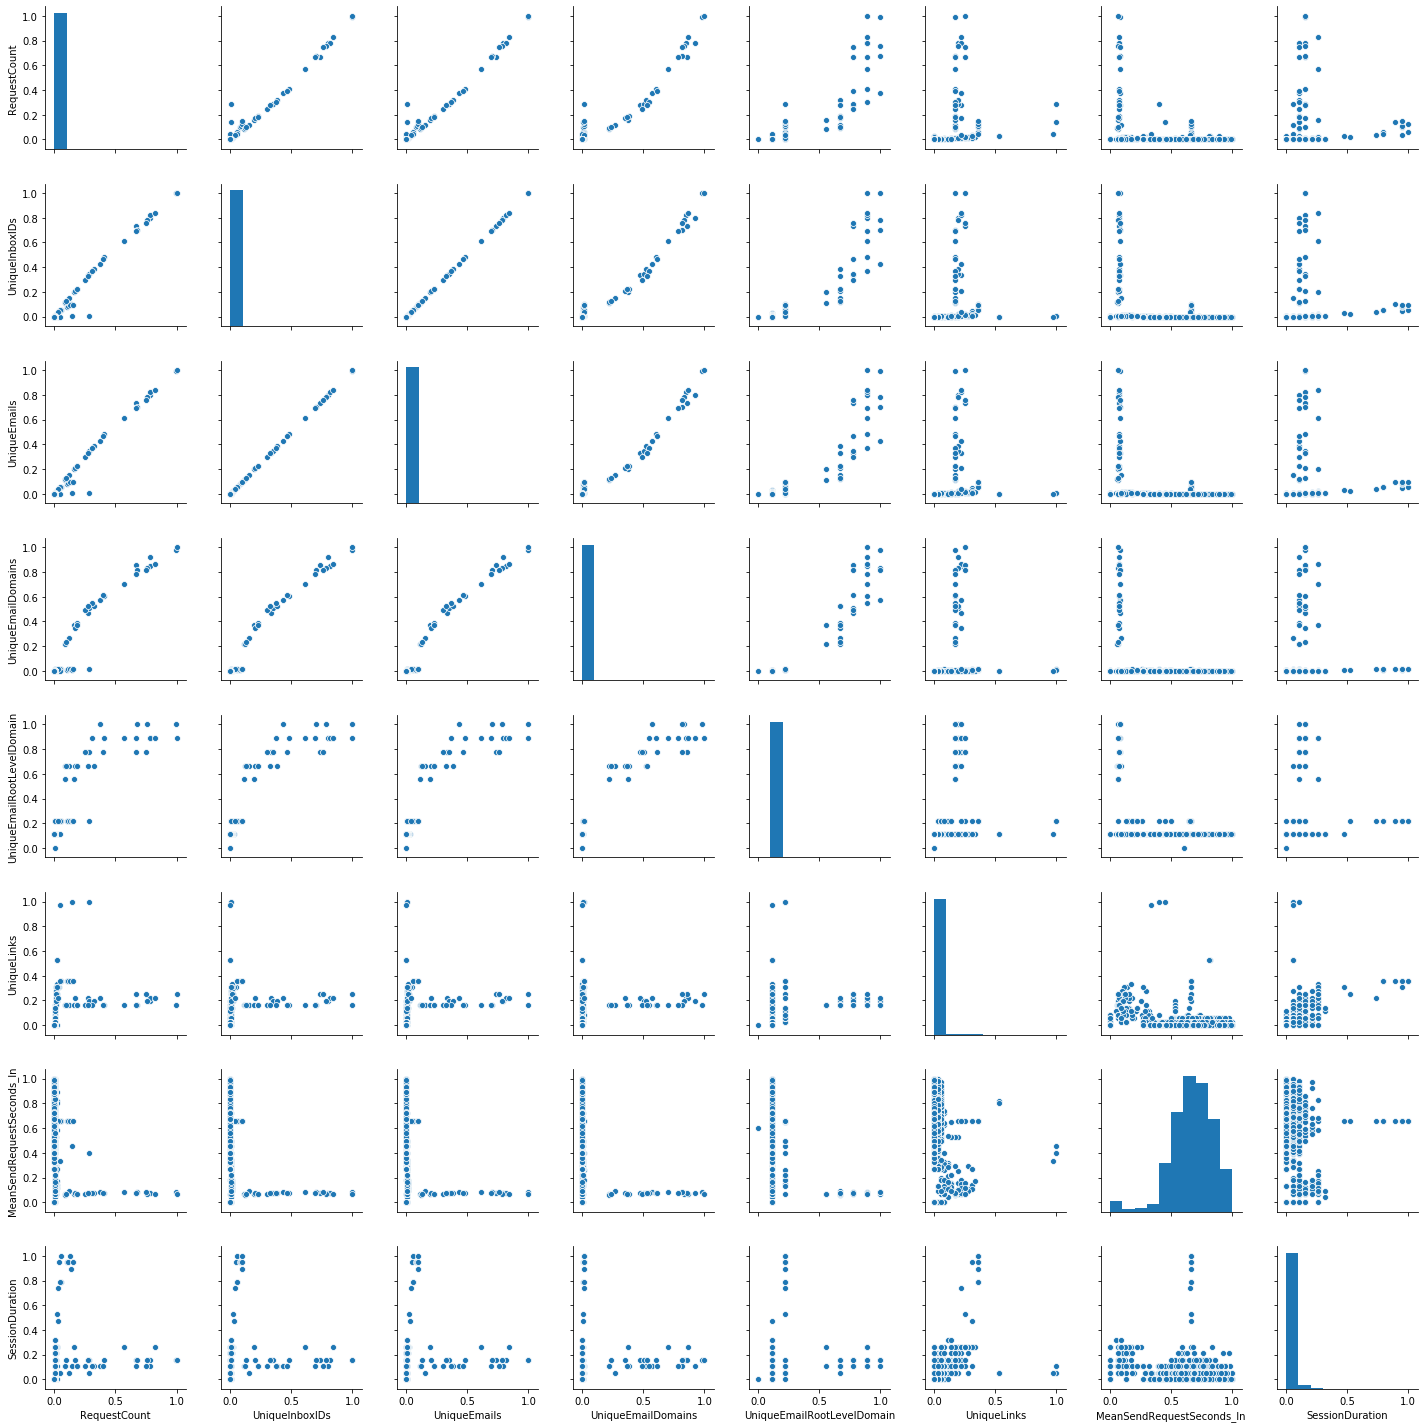

In [15]:
sns.pairplot(df_IPUA_agg_unsup_s)

# DBSCAN IP/UA Session

In [16]:
from sklearn.cluster import DBSCAN
filename = 'C:/data/IPUA_DBSCAN.model'
build_new_model = True
if not path.exists(filename):
    build_new_model = True
    
if build_new_model:
    model = DBSCAN(eps=.4, min_samples=2, n_jobs=-1)
    model.fit(df_IPUA_agg_unsup_s)
    pickle.dump(model, open(filename, 'wb'))
else:
    model = pickle.load(open(filename, 'rb'))

labels = model.labels_

print('Number of clusteres found = {}'.format(np.nanmax(labels)))

Number of clusteres found = 3


## Append the DBSCAN Lables to the 2 IP group by DataFrames

In [17]:
df_IPUA_agg['IPUA_Labels'] = labels #Origional Group By with additional agg columns
df_IPUA_agg_unsup['IPUA_Labels'] = labels #Normilized Aggregations
df_IPUA_agg_unsup_s['IPUA_Labels'] = labels #Not=Normilized Aggregations

## Build visualizations to manually inspect effectiveness of clusters

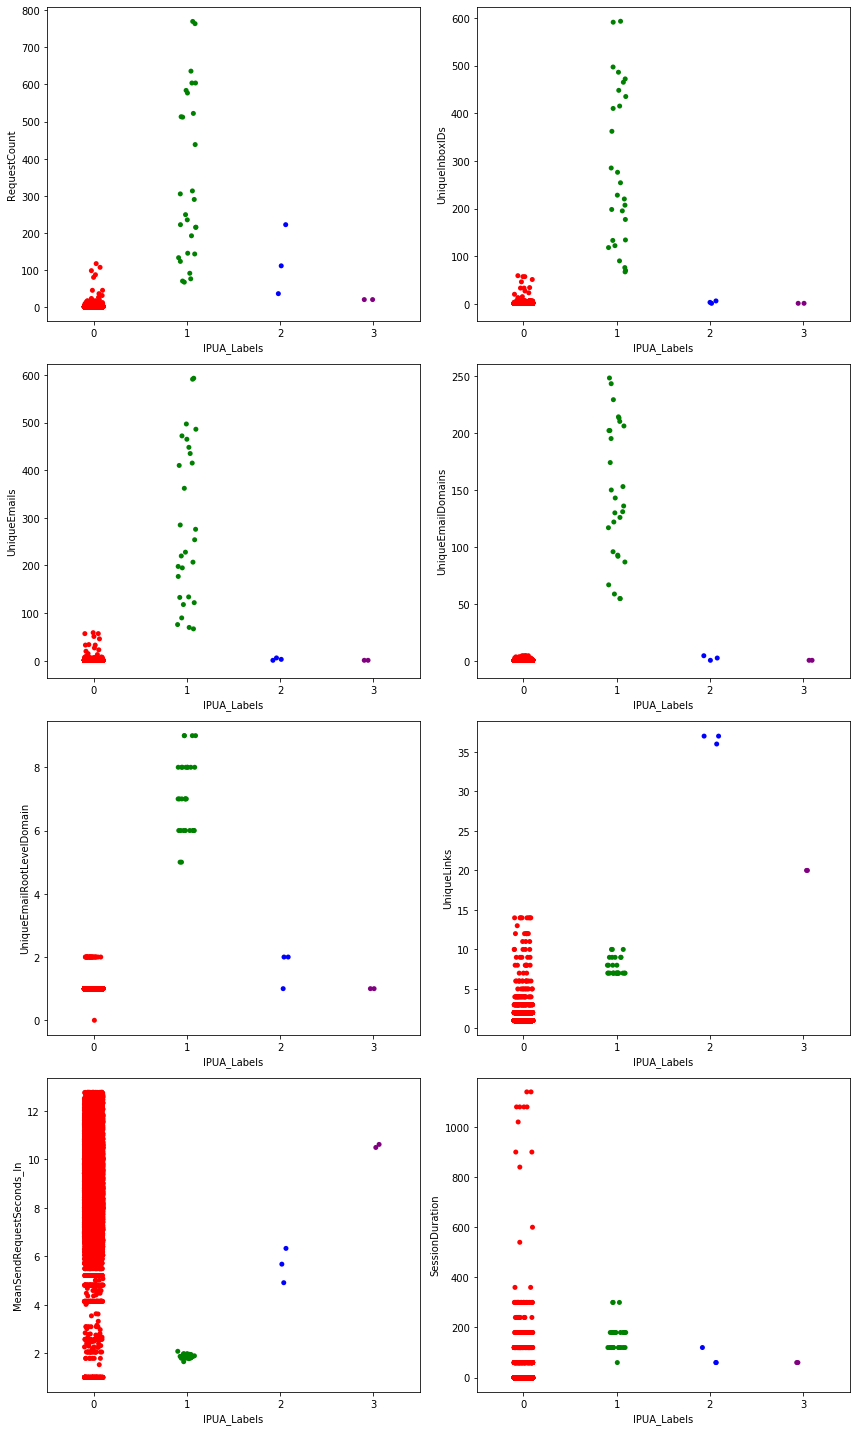

In [18]:
palette = {0:'r', 1:'g',2:'b', 3:'purple', 4:'cyan', 5:'black'}
i = 0
j = 0
row_count = len(IPUA_unsup_columns) // 2
f = plt.figure(figsize=(12, 20))
gs = f.add_gridspec(row_count, 2)

for feature in IPUA_unsup_columns:
    ax = f.add_subplot(gs[i, j])
    sns.stripplot(x='IPUA_Labels', y=feature, palette=palette, data=df_IPUA_agg)
    if j == 1:
        j = 0
        i += 1
    else:
        j += 1

f.tight_layout()
plt.show()

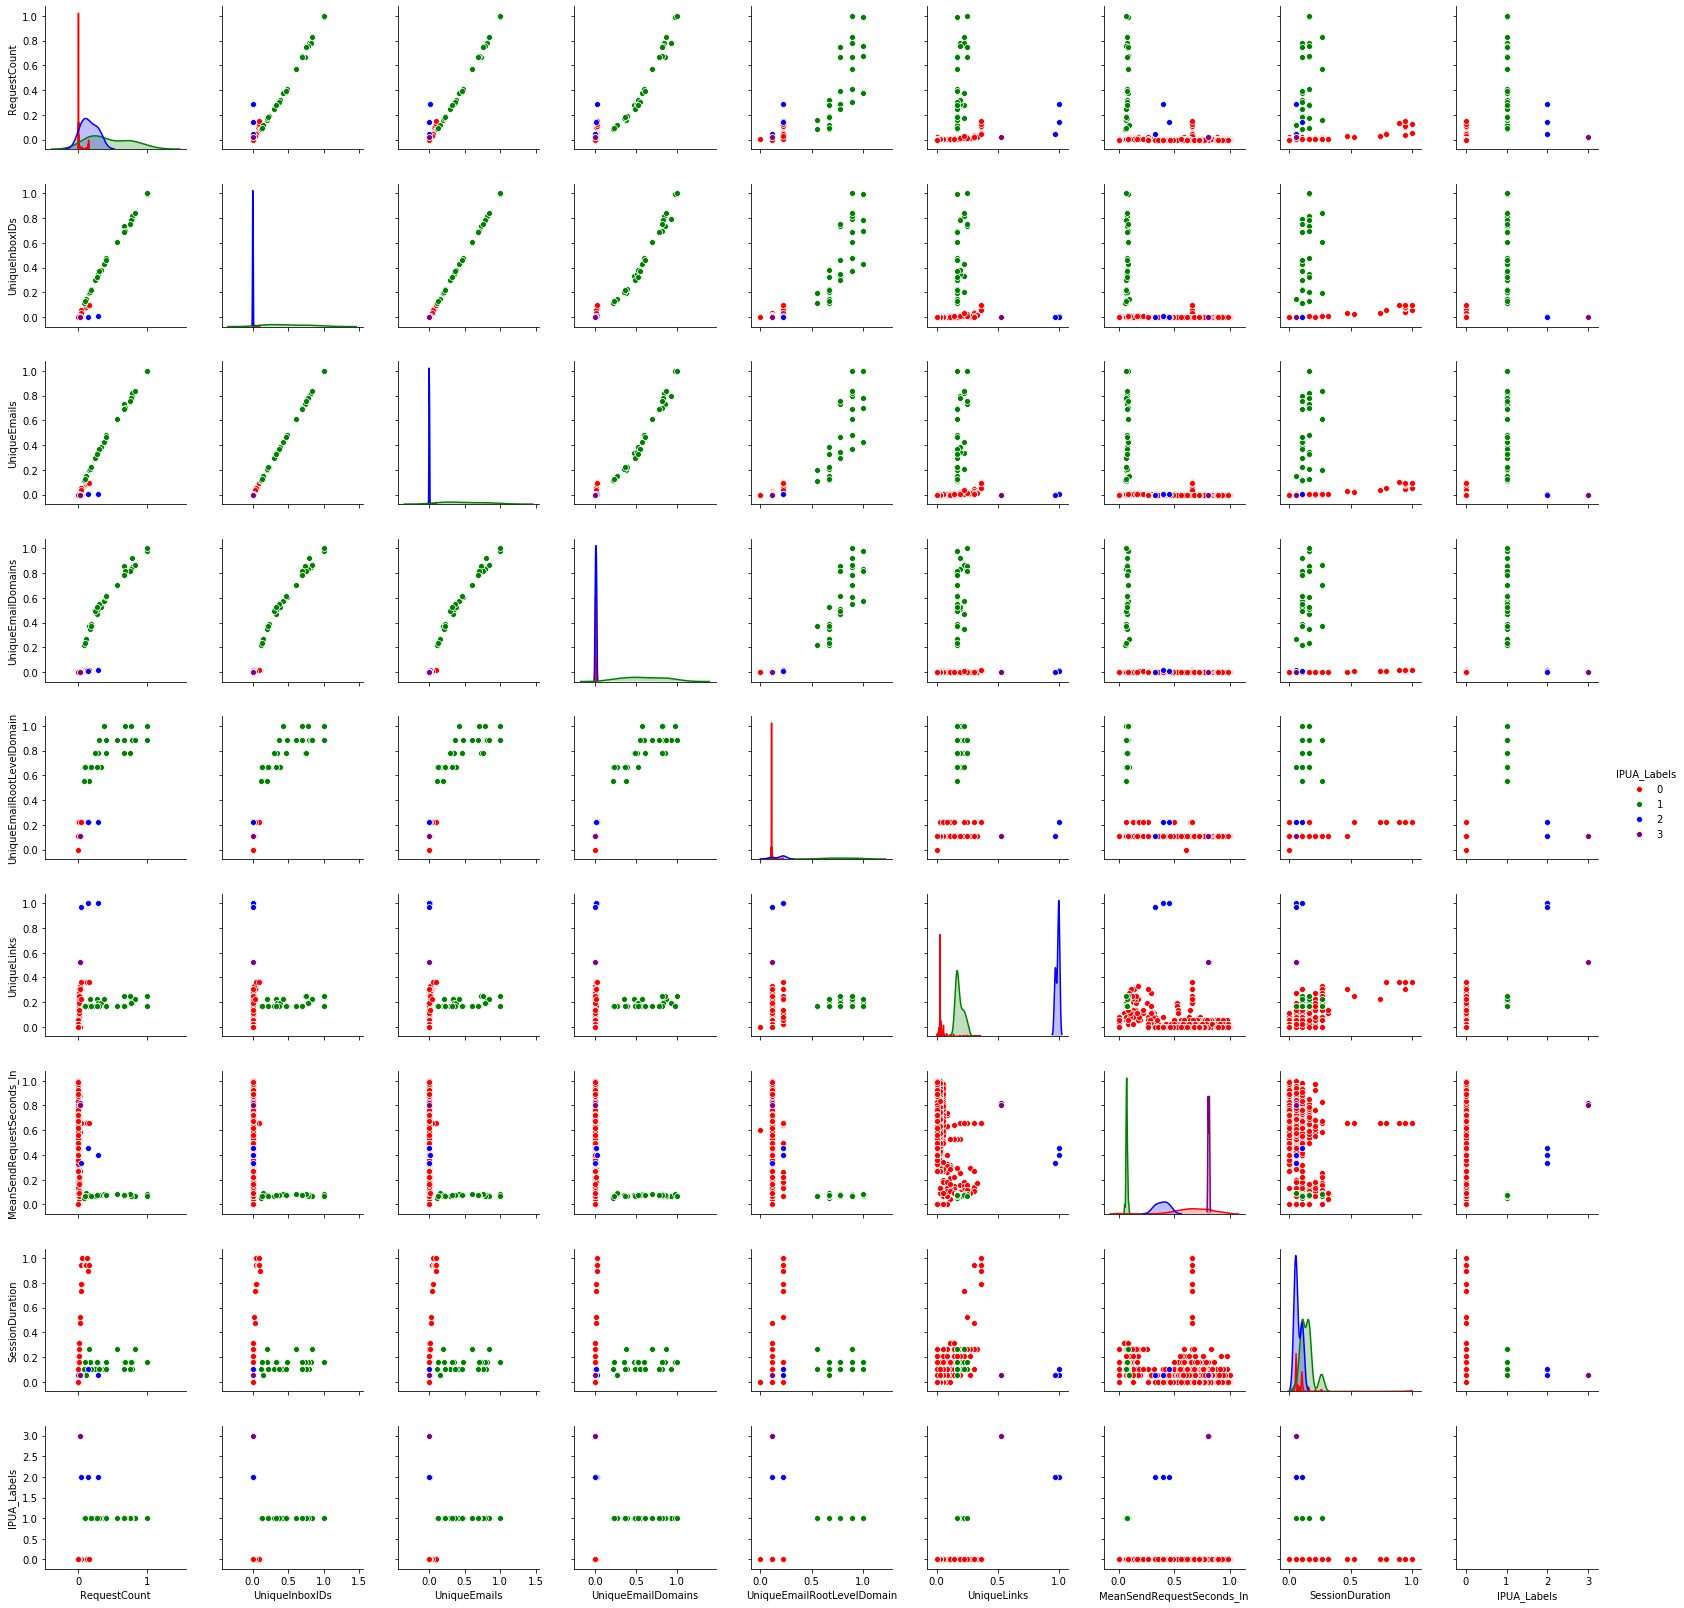

In [19]:
np.seterr(divide='ignore', invalid='ignore')
sns.pairplot(df_IPUA_agg_unsup_s, hue='IPUA_Labels', palette=palette)

# Merge the DBSCAN labels for IP/US GroupBy with original df

## Remember, so far we have been looking at the group by DataFrame

Now that we merged the DBSCAN Lables into the raw date, we will see different cardinality then our groupby dataframes.  This is because many rows from the origional DataFrame can have the same IP and User Agent

In [20]:
df = botDataSet.df
df_IPUA_clusters = pd.merge(df, df_IPUA_agg['IPUA_Labels'], on="IPUASessionID")

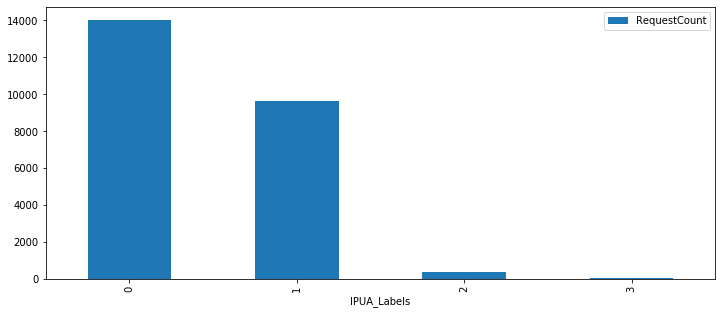

In [21]:
p= pd.DataFrame(df_IPUA_clusters.groupby(['IPUA_Labels'])['InboxID'].count())
p = p.unstack(0, )
p = p.reset_index('IPUA_Labels')
p.columns = ['IPUA_Labels', 'RequestCount']
p.plot.bar('IPUA_Labels', 'RequestCount', figsize=(12,5))

In [22]:
nunique_columns = [ 'InboxID',
                    'Company',
                    'List',
                    'Campaign',
                    'Link',
                    'IPAddress',
                    'UserAgent',
                    'AS Name',
                    'AS Number',
                    'CIDR Range',
                    'EmailDomain',
                    'EmailRootLevelDomain']
gb = df_IPUA_clusters.groupby(['IPUA_Labels'])[nunique_columns].nunique()
gb=gb.transpose()
gb

IPUA_Labels,0,1,2,3
InboxID,10154,1409,10,2
Company,1,1,1,1
List,1,1,1,1
Campaign,1,1,1,1
Link,37,12,37,27
IPAddress,10327,28,2,2
UserAgent,1177,1,2,2
AS Name,21,1,2,1
AS Number,22,1,2,1
CIDR Range,353,11,2,2


## Show distribution of these labels across the AS Names

In [23]:
def groupByPivot(group_column_top, group_column_left, count_column):
    gb = df_IPUA_clusters.groupby([group_column_top, group_column_left])[count_column].count()
    gb.fillna(0, inplace=True)
    gb = gb.unstack(0)
    gb.fillna(0, inplace=True)
    gb['All'] = gb[0] + gb[1] + gb[2] + gb[3] #+ gb[4]  
    gb.sort_values('All', ascending=False, inplace=True)
    return gb

In [24]:
groupByPivot('IPUA_Labels', 'AS Name','InboxID')

IPUA_Labels,0,1,2,3,All
AS Name,,,,,
"Amazon.com, Inc.",1158.0,9608.0,333.0,40.0,11139.0
Unknown,10562.0,0.0,0.0,0.0,10562.0
AT&T Mobility LLC,1118.0,0.0,0.0,0.0,1118.0
"MCI Communications Services, Inc. Verizon Business",294.0,0.0,0.0,0.0,294.0
"T-Mobile USA, Inc.",253.0,0.0,0.0,0.0,253.0
Scalair SAS,217.0,0.0,0.0,0.0,217.0
"CenturyLink Communications, LLC",91.0,0.0,0.0,0.0,91.0
Google LLC,86.0,0.0,0.0,0.0,86.0
"Comcast Cable Communications, LLC",81.0,0.0,0.0,0.0,81.0


In [25]:
groupByPivot('IPUA_Labels', 'AS Number','InboxID')

IPUA_Labels,0,1,2,3,All
AS Number,,,,,
Unknown,10562.0,0.0,0.0,0.0,10562.0
16509,261.0,9608.0,0.0,40.0,9909.0
14618,897.0,0.0,333.0,0.0,1230.0
20057,1118.0,0.0,0.0,0.0,1118.0
701,294.0,0.0,0.0,0.0,294.0
21928,253.0,0.0,0.0,0.0,253.0
206002,217.0,0.0,0.0,0.0,217.0
209,91.0,0.0,0.0,0.0,91.0
15169,86.0,0.0,0.0,0.0,86.0


In [26]:
groupByPivot('IPUA_Labels', 'CIDR Range','InboxID').head(20)

IPUA_Labels,0,1,2,3,All
CIDR Range,,,,,
Unknown,10562.0,0.0,0.0,0.0,10562.0
{4ED21F0C-8573-052A-670B-E4D315133AF5},75.0,3823.0,0.0,0.0,3898.0
{7EF79BFD-BC3A-903D-C2BD-F5E295ACF4DE},18.0,1731.0,0.0,0.0,1749.0
{E3615A90-F5C2-C4A8-40A1-2CCC4102B390},7.0,812.0,0.0,0.0,819.0
{D2185CAC-6E67-82FB-603B-F5B33514B577},9.0,781.0,0.0,0.0,790.0
{F9164193-183A-7A69-1AE7-25BD6243ED72},9.0,596.0,0.0,0.0,605.0
{11E5AB29-4623-8156-AB63-E7A2FD82A79A},6.0,584.0,0.0,0.0,590.0
{60D94A4C-7F09-D0F9-2810-83B93ACBC03E},12.0,438.0,0.0,0.0,450.0
{7E737FAE-7868-5BE1-84B6-EA9011F3B32E},33.0,0.0,333.0,0.0,366.0


### Save lables to csv file for manual analysis with raw non-anonymized data in SQL.

In [27]:
select_columns = ['IPAddress', 'IPUA_Labels']
output = df_IPUA_clusters[select_columns].copy()
output.drop_duplicates(inplace=True)
output.to_csv('C:/data/IPUA_Lables.csv')
output

,IPAddress,IPUA_Labels
0,{9AD7D4CE-E247-DA9B-6E99-F5255E45F42F},0
1,{6AC33884-ADE3-2F3E-6DD7-1731EC5D2945},1
223,{0793D471-B890-C0C1-2C0B-DF4882B1D58C},1
735,{907BAFFD-A66B-2D34-89B1-768E3FCBD951},1
1505,{41D3D20E-D0C2-80D5-90F7-1DFE369F08E8},1
...,...,...
24053,{00497147-0F77-6B45-0E45-B36ED3AF4D12},0
24054,{E2E0C2B4-4BF9-4060-EB34-713606ED4792},0
24055,{002769C7-24CA-4DC3-4ECB-2C50E6789D3B},0
24056,{444E7332-C3E7-86B0-0315-66B39B1A2D7C},0
